In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn import manifold, decomposition, linear_model, ensemble, neighbors, cross_validation
%matplotlib inline
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt

from heamy.dataset import Dataset
from heamy.estimator import Regressor, Classifier
from heamy.pipeline import ModelsPipeline

/Users/d.parpulov/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def rmse(x,y):
    return np.mean((x - y) ** 2) ** 0.5

## Подготовка данных (urls)

In [10]:
urls_train_df = pd.read_csv('data/url_domain_train', header=None, delimiter='\t')
urls_train_df.columns = ['id', 'url', 'count']
urls_train_df = urls_train_df[['id', 'url']]

In [11]:
urls_train_df.head()

,id,url
0,000000014B60815F65B38258011B6C01,login.rutracker.org
1,000000014B60815F65B38258011B6C01,rutracker.org
2,000000014C03DA2A47AC433A0C755201,admin.tour-spb.net
3,000000014C03DA2A47AC433A0C755201,czinfo.ru
4,000000014C03DA2A47AC433A0C755201,forumsostav.ru


In [12]:
urls_train_df = pd.DataFrame(urls_train_df.groupby('id')['url'].apply(lambda x: x.tolist()))
urls_train_df['id'] = urls_train_df.index
urls_train_df.index = range(len(urls_train_df))
urls_train_df.columns = ['urls', 'id']

In [13]:
urls_train_df.head()

,urls,id
0,"[id.rambler.ru, mail.rambler.ru, r0.ru]",000000013CB5719C0000A2C90002C101
1,"[1prime.ru, autorambler.ru, chellak.ru, docs.c...",00000001442BE24000001B7D00F50801
2,[bosch-korolev.ru],00000001448580F800003F1B31FB0901
3,"[aptekanizkihcen.ua, colady.ru, gorod.dp.ua, i...",0000000145BDB2FF000157971645E901
4,"[astrorok.ru, diets.ru, edaplus.info, eshzdoro...",000000014602771F0000DB9359714C01


In [14]:
age_train_df = pd.read_csv('data/age_profile_train', header=None, delimiter='\t')
age_train_df.columns = ['id', 'age']

In [15]:
age_train_df.head()

,id,age
0,000000013CB5719C0000A2C90002C101,53
1,00000001442BE24000001B7D00F50801,48
2,00000001448580F800003F1B31FB0901,28
3,0000000145BDB2FF000157971645E901,44
4,000000014602771F0000DB9359714C01,48


In [16]:
train_df = urls_train_df.merge(age_train_df, on='id', how='left')

In [17]:
train_df.head()

,urls,id,age
0,"[id.rambler.ru, mail.rambler.ru, r0.ru]",000000013CB5719C0000A2C90002C101,53
1,"[1prime.ru, autorambler.ru, chellak.ru, docs.c...",00000001442BE24000001B7D00F50801,48
2,[bosch-korolev.ru],00000001448580F800003F1B31FB0901,28
3,"[aptekanizkihcen.ua, colady.ru, gorod.dp.ua, i...",0000000145BDB2FF000157971645E901,44
4,"[astrorok.ru, diets.ru, edaplus.info, eshzdoro...",000000014602771F0000DB9359714C01,48


## Снижение размерности

In [18]:
train_df.shape

(118603, 3)

In [38]:
topk = 300000
X, y = train_df.urls.values[:topk], train_df.age.values[:topk]

In [39]:
X[:5]

array([['id.rambler.ru', 'mail.rambler.ru', 'r0.ru'],
       ['1prime.ru', 'autorambler.ru', 'chellak.ru', 'docs.cntd.ru', 'echo.msk.ru', 'expert.ru', 'finance.rambler.ru', 'forbes.ru', 'forum.ixbt.com', 'garant.ru', 'govoritmoskva.ru', 'kommersant.ru', 'kp.ru', 'lenta.ru', 'mait.ru', 'metronews.ru', 'mk.ru', 'news.rambler.ru', 'news.smi2.ru', 'norm-load.ru', 'pfr.kirov.ru', 'pfrf.ru', 'photography-on-the.ru', 'realty.rambler.ru', 'ren.tv', 'riafan.ru', 'rns.online', 'rossbanki.ru', 'secretmag.ru', 'tehnorma.ru', 'tiu.ru', 'top68.ru', 'tvc.ru', 'tvzvezda.ru', 'vesti.ru', 'video.rambler.ru', 'weekend.rambler.ru'],
       ['bosch-korolev.ru'],
       ['aptekanizkihcen.ua', 'colady.ru', 'gorod.dp.ua', 'i.ovkuse.ru', 'love.mail.ru', 'medinform.in.ua', 'nbnews.com.ua', 'podrobnosti.ua', 'segodnya.ua', 'tyzhden.ua'],
       ['astrorok.ru', 'diets.ru', 'edaplus.info', 'eshzdorovo.ru', 'gotovim.ru', 'inmoment.ru', 'menslife.com', 'nostress.ru', 'receptdolgoletia.ru', 'zdorovie-krasnodar.ru', '

In [40]:
url_frequency = pd.Series([j for i in X for j in i]).value_counts()

In [41]:
url_frequency.head(10)

mail.rambler.ru        88443
rambler.ru             59960
news.rambler.ru        32764
mail-pda.rambler.ru    24726
rns.online             14527
id.rambler.ru          13699
weekend.rambler.ru     13499
video.rambler.ru       13494
ren.tv                 12423
m.rambler.ru           12002
dtype: int64

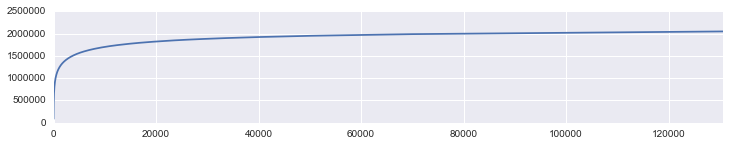

In [42]:
url_frequency = pd.Series([j for i in X for j in i]).value_counts()
url_frequency.index = range(len(url_frequency))

url_frequency.cumsum().plot(figsize=(12,2))

In [43]:
%%time
X = map(lambda x: ' '.join(x), X)
hw = HashingVectorizer(n_features=1000, non_negative=True).fit(X)
X = hw.transform(X).todense()

CPU times: user 16.2 s, sys: 885 ms, total: 17.1 s
Wall time: 18.1 s


In [44]:
X.shape

(118603, 1000)

In [ ]:
%%time

transformer = sklearn.decomposition.NMF(n_components=100)
X_nmf = transformer.fit_transform(X)

## Холдаут

In [36]:
itrain, itest = cross_validation.train_test_split(range(len(X)), test_size=1./3, random_state=0)
len(itrain), len(itest)

(20000, 10000)

## Обучение модели

In [37]:
rmse(y[itest], np.mean(y[itrain]))

13.115139496017571

In [156]:
reg = LinearRegression()
reg.fit(X[itrain, :], y[itrain])

pred_X = reg.predict(X[itest, :])
print rmse(y[itest], pred_X)

11.9053939779


In [157]:
reg = LinearRegression()
reg.fit(X_nmf[itrain, :], y[itrain])

pred_X_nmf = reg.predict(X_nmf[itest, :])
print rmse(y[itest], pred_X_nmf)

12.0059923586


11.8794101395


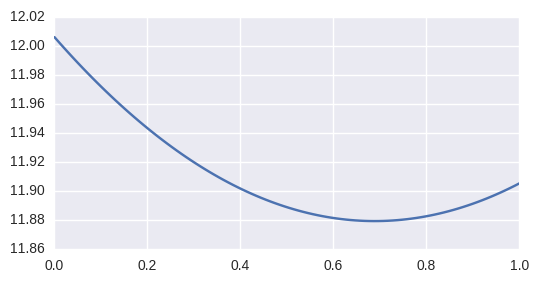

In [169]:
error = []
for w in np.linspace(0, 1, 100):
     error += [rmse(y[itest], pred_X * w + (1-w) * pred_X_nmf)]

pd.Series(error, index=np.linspace(0, 1, 100)).plot(figsize=(6,3))
print min(error)

## Blenging с помощью heamy
pip install heamy

https://github.com/rushter/heamy

In [187]:
from sklearn import pipeline, preprocessing, feature_extraction

In [195]:
# %%time

# обычный датасет
dataset1 = Dataset(X[itrain, :], y[itrain], X[itest, :])
# NMF
dataset2 = Dataset(X_nmf[itrain, :], y[itrain], X_nmf[itest, :])

# линейная модель на обычных данных
lr = Regressor(dataset=dataset1, 
                     estimator=linear_model.LinearRegression,
                     parameters={'normalize': True},
                     name='lr')

# линейная модель на TFIDF от обычных данных
def tfidf_lr_(X_train, y_train, X_test, y_test=None, random_state=8888):
    model = pipeline.Pipeline([('tfidf', feature_extraction.text.TfidfTransformer()), 
                                ('linear_model', linear_model.LinearRegression())])
    model.fit(X_train, y_train)
    return model.predict(X_test)

tfidf_lr = Regressor(dataset=dataset1,
                     estimator=tfidf_lr_,
                     name='tfidf_lr')

# ExtraTrees на NMF
rf = Regressor(dataset=dataset2, 
                     estimator=ensemble.ExtraTreesRegressor,
                     parameters={'n_estimators': 100, 'n_jobs': -1},
                     name='rf')

# Stack two models
# Returns new dataset with out-of-fold predictions
meta_pipeline = ModelsPipeline(lr, tfidf_lr, rf)
stack_ds = meta_pipeline.blend(proportion=0.2,seed=111)

# Train LinearRegression on stacked data (second stage)
stacker = Regressor(dataset=stack_ds, estimator=LinearRegression)
results = stacker.predict()

print rmse(y[itest], results)

11.77521733
